In [2]:
import os.path
import pandas as pd
import plotly as py
import plotly.express as px
import matplotlib.pyplot as plt
import glob
import gzip
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import multiprocessing as mp

# Load and preprocess sensor data
Because of the huge size of this data, loading it takes many hours. I often had crashes while trying to find the best way to preprocess. To make sure I don't have to start all over again, I frequently saved the current data frame to csv, i.e., I had multiple "checkpoints".

## Load all files from NDW/flow/input that end with 05-08
This means that they have the data for the times between 5am and 9am.
</br> The resulting data frame is used in link_obs_exp.ipynb to get the observed counts. After this step, I inspect the data (mostly a sample of the data) and create another data frame that contains the location and region of each sensor. This is also used in link_obs_exp to merge to the observed counts and that data frame can be found at the end of this script.

In [ ]:
# all vehicles that are smaller than 5.6 (not all sensors can make that distinction - these are ignored)
# this did not work the first time, but the second time it did. weird
path = r'/data2/NDW/flow/input'
times = ("/*05.csv.gz", "/*06.csv.gz", "/*07.csv.gz", "/*08.csv.gz") # the tuple of file types
all_files = []
for files in times:
    all_files.extend(glob.glob(path + files))

result_list=[]

for filename in all_files:
    with open(filename, 'rb') as file:  # this will ensure that only one file is opened at the same time
               
                #read file
                gzip_file = gzip.GzipFile(fileobj=file) #to decompress the gzip file
                dat = pd.read_csv(gzip_file)
                dat = dat[dat["index"].isin(["1C","2C","1B","13C","14C","9B","25C","26C","17B","37C","38C","25B","49C","50C","33B","201C","202C","201B","301C","302C","301B","501C","502C","501B","601C","602C","601B","701C","702C","702B","801C","802C","801B","401C","402C","401B","61C","62C","41B","73C","74C","49B","85C","86C","57B","97C","98C","65B","109C","110C","73B"])]
                
                #preprocess traffic counts
                dat = dat.loc[dat['value'] % 60 == 0] # to remove implausible values in "value", since they should be the observed count times 60
                dat["value"] = dat["value"] / 60 #divide each value observation by 60 to get the actual count per minute
                dat["values_used"] = dat["values_used"].replace(np.nan, np.inf) #for the aggregation, python treats NaNs as 0's. To circumvent that, I change them to np.inf
                dat = dat.groupby(["location_id", "time"], as_index = False).sum()
                dat["values_used"] = dat["values_used"].replace(np.inf, np.nan) #change np.inf back to NaN
                
                #preprocess time column
                dat["time"] = dat["time"].str.replace("T", " ")
                dat["time"] = dat["time"].str.replace("Z", " ")
                dat['time'] = pd.to_datetime(dat['time'], format='%Y-%m-%d %H:%M:%S')
                dat["date"] = dat["time"].dt.date #extract date from datetime
                dat["month"] = dat["time"].dt.month #extract month from datetime
                
                result_list.append(dat)

entire_rushhour = pd.concat(result_list, axis=0, ignore_index=True)
entire_rushhour.to_csv('entire_rushhour_shortssummed.csv', index=False) 

In [2]:
#entire_rushhour = pd.read_csv('entire_rushhour_shortssummed.csv')

## Format the time column
Because of the size of the data frame, this does not work straightforwardly. I first split the data frame into three smaller frames, and then performed multiprocessing on each of these data frames. The CBS server has 24 processing cores, but this still took quite a while.

In [3]:
len(entire_rushhour.index)

524379951

In [11]:
(524379951/3)

349586634.0

In [12]:
df1 = entire_rushhour.iloc[:174793317]
df2 = entire_rushhour.iloc[174793318:349586634]
df3 = entire_rushhour.iloc[349586635:524379951]

In [13]:
df1.to_csv('df1entire_rushhour_shortssummed.csv', index=False) 
df2.to_csv('df2entire_rushhour_shortssummed.csv', index=False) 
df3.to_csv('df3entire_rushhour_shortssummed.csv', index=False) 

In [3]:
import multiprocessing
def replace_letters(dat):
    #output_dat = dat.copy()
    
    dat["time"] = dat["time"].apply(lambda text: text.replace("T", " "))
    dat["time"] = dat["time"].apply(lambda text: text.replace("Z", " "))
    
    return dat
    
NUM_CORES = 24

In [15]:
dat_chunks = np.array_split(df1, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:
    
    processed_df = pd.concat(pool.map(replace_letters, dat_chunks), ignore_index = True)

processed_df.to_csv('df1entire_rushhour_shortssummed.csv', index=False) 

In [18]:
processed_df['time'] = pd.to_datetime(processed_df['time'], format='%Y-%m-%d %H:%M:%S')
processed_df["date"] = processed_df["time"].dt.date #extract date from datetime
processed_df["month"] = processed_df["time"].dt.month #extract month from datetime
processed_df.to_csv('df1entire_rushhour_shortssummed.csv', index=False) 

,location_id,time,value,values_used
0,GAD02_Amstd_29_0,2019-06-24 05:00:00,2.0,NaN
1,GAD02_Amstd_29_0,2019-06-24 05:01:00,2.0,NaN
2,GAD02_Amstd_29_0,2019-06-24 05:02:00,5.0,NaN
3,GAD02_Amstd_29_0,2019-06-24 05:03:00,2.0,NaN
4,GAD02_Amstd_29_0,2019-06-24 05:04:00,3.0,NaN


In [5]:
df2 = pd.read_csv('df2entire_rushhour_shortssummed.csv') 
dat_chunks = np.array_split(df2, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:
    
    processed_df = pd.concat(pool.map(replace_letters, dat_chunks), ignore_index = True)

processed_df['time'] = pd.to_datetime(processed_df['time'], format='%Y-%m-%d %H:%M:%S')
processed_df["date"] = processed_df["time"].dt.date #extract date from datetime
processed_df["month"] = processed_df["time"].dt.month #extract month from datetime    
processed_df.to_csv('df2entire_rushhour_shortssummed.csv', index=False) 

In [6]:
df3 = pd.read_csv('df3entire_rushhour_shortssummed.csv') 
dat_chunks = np.array_split(df3, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:
    
    processed_df = pd.concat(pool.map(replace_letters, dat_chunks), ignore_index = True)

processed_df['time'] = pd.to_datetime(processed_df['time'], format='%Y-%m-%d %H:%M:%S')
processed_df["date"] = processed_df["time"].dt.date #extract date from datetime
processed_df["month"] = processed_df["time"].dt.month #extract month from datetime
processed_df.to_csv('df3entire_rushhour_shortssummed.csv', index=False) 

In [3]:
df1 = pd.read_csv('df1entire_rushhour_shortssummed.csv') 
df2 = pd.read_csv('df2entire_rushhour_shortssummed.csv')
df3 = pd.read_csv('df3entire_rushhour_shortssummed.csv')
frames = [df1, df2, df3]
entire_rushhour = pd.concat(frames)

In [2]:
entire_rushhour = pd.read_csv('entire_rushhour_shortssummed_datetime.csv') 

### Take random 10% sample of all measurements
This will still be millions of rows, so preprocessing is still slow. But it is a workable solution.

Time is not a datetime in the entire rushhour and there is no hour-column. But file is too large to use the entire file anyway, creating column in 10% sample is doable

In [3]:
entire_rushhour['time'] = pd.to_datetime(entire_rushhour['time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
entire_rushhour['hourminute'] = entire_rushhour["time"].dt.strftime('%H:%M')

In [4]:
entire_rushhour.to_csv('entire_rushhour_shortssummed_datetime.csv', index=False) 

In [4]:
sampled_rushhour = entire_rushhour.sample(frac = 0.1)

In [5]:
sampled_rushhour['hourminute'] = sampled_rushhour["time"].dt.strftime('%H:%M')

In [55]:
sampled_rushhour.to_csv("sampled_rushhour.csv", index = False)
sampled_rushhour = pd.read_csv("sampled_rushhour.csv")

In [3]:
sampled_rushhour = pd.read_csv("sampled_rushhour.csv")

In [12]:
pd.DataFrame.head(sampled_rushhour)

,location_id,time,value,values_used,date,month,hourminute
0,RWS01_MONICA_00D01B038C19D0070007,2019-09-03 06:40:00,27.0,NaN,2019-09-03,9,06:40
1,RWS01_MONICA_00D01008A04BD0050005,2019-12-12 05:48:00,33.0,NaN,2019-12-12,12,05:48
2,RWS01_MONICA_00D01C03445FD0070087,2019-12-17 07:59:00,16.0,NaN,2019-12-17,12,07:59
3,RWS01_MONICA_00D00C0A6837D007000F,2019-12-01 06:16:00,1.0,NaN,2019-12-01,12,06:16
4,GEO0C_Z_RWSTI357715,2019-08-28 08:28:00,11.0,11.0,2019-08-28,8,08:28


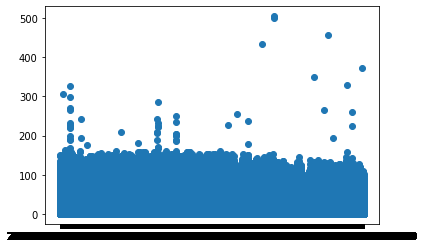

In [3]:
plt.scatter(x = entire_rushhour["time"], y = entire_rushhour["value"])
plt.show()

This plot shows us that there are some outliers in the data, but besides that, it is difficult to get a good look at the intensity over time. We can group by hourminute (hh:mm) to get a better look.

In [7]:
sampled_rushhour_grouped = sampled_rushhour[["location_id", "hourminute", "value", "values_used"]]
sampled_rushhour_grouped = sampled_rushhour.groupby(["location_id", "hourminute"], as_index = False).mean()

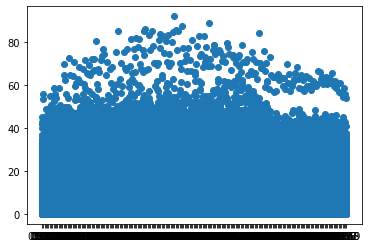

In [8]:
plt.scatter(x = sampled_rushhour_grouped["hourminute"], y = sampled_rushhour_grouped["value"])
plt.show()

Group by hourminute (hh:mm) to look at intensity over the rush hour, and to see the peak of the rush hour

In [55]:
hourgrouped = sampled_rushhour[["hourminute", "value", "values_used"]]
hourgrouped = sampled_rushhour.groupby(["hourminute"], as_index = False).mean()
hourgrouped["hourminute"] = pd.to_datetime(hourgrouped["hourminute"], format='%H:%M')

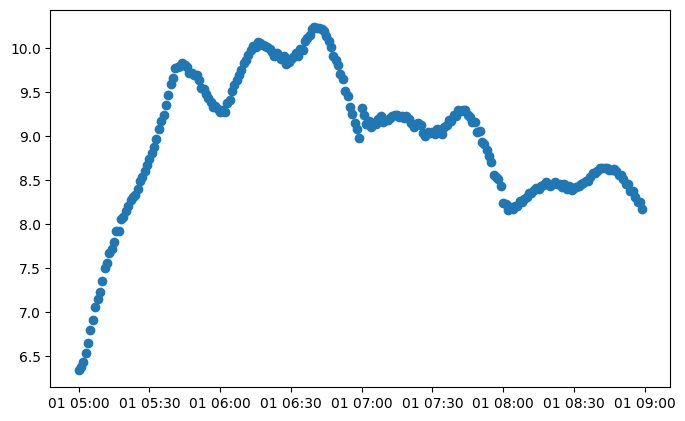

In [17]:
from matplotlib.pyplot import figure

figure(figsize = (8, 5), dpi = 100)
plt.scatter(x = hourgrouped["hourminute"], y = hourgrouped["value"])
plt.show()

Look at one single sensor

In [20]:
amsterdam = entire_rushhour.loc[entire_rushhour["location_id"] == "GAD02_Amstd_29_0"]

In [22]:
amsterdam['hourminute'] = amsterdam["time"].dt.strftime('%H:%M')
amsterdam_hourgroup =  amsterdam.groupby(["hourminute"], as_index = False).mean()
amsterdam_daysum =  amsterdam.groupby(["date"], as_index = False).sum()

<ipython-input-22-668787261df5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amsterdam['hourminute'] = amsterdam["time"].dt.strftime('%H:%M')


Intensity grouped by hourminute for one single sensor:

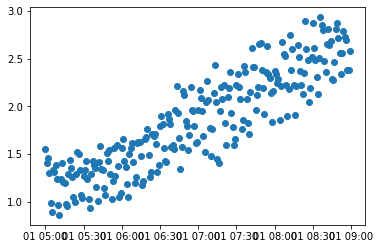

In [24]:
amsterdam_hourgroup["hourminute"] = pd.to_datetime(amsterdam_hourgroup["hourminute"], format='%H:%M')
plt.scatter(x = amsterdam_hourgroup["hourminute"], y = amsterdam_hourgroup["value"])
plt.show()

Daily sum for one single sensor

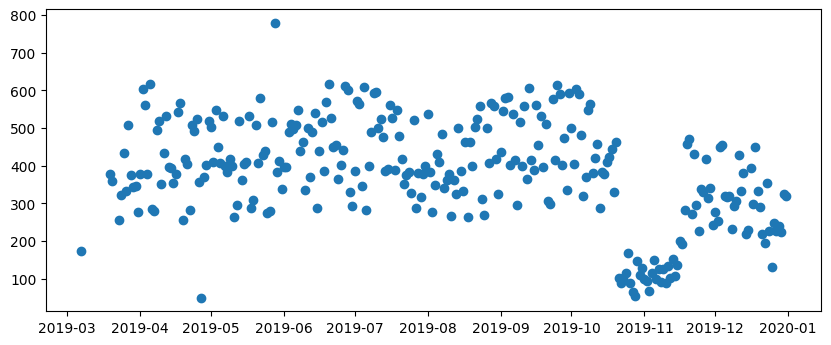

In [35]:
amsterdam_daysum["date"] = pd.to_datetime(amsterdam_daysum["date"], format='%Y-%m-%d')

figure(figsize = (10, 4), dpi = 100)
plt.scatter(x = amsterdam_daysum["date"], y = amsterdam_daysum["value"])
plt.show()

## Load configuration data, prepare longlat and merge to the sampled dataframe

In [13]:
# First load configuration data
meta = pd.read_csv("meta211121.csv")

In [14]:
meta.rename(columns={'dgl_loc':'location_id'}, inplace=True)
meta = meta[["coordinates", "location_id"]] #drop unnecessary columns

In [15]:
import multiprocessing
def replace_letters(meta):
    #output_dat = dat.copy()
    
    meta[["longitude", "latitude"]] = meta["coordinates"].str.split(",", expand = True)
    meta["longitude"] = meta["longitude"].str[1:]
    meta["latitude"] = meta["latitude"].str.rstrip("]")
    
    return meta
    
NUM_CORES = 24

In [16]:
dat_chunks = np.array_split(meta, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:
    
    meta = pd.concat(pool.map(replace_letters, dat_chunks), ignore_index = True)


In [17]:
dat = sampled_rushhour.merge(meta, on='location_id')

## Plot daily intensity on map

Group by date to get the daily mean traffic intensity per sensor 

In [63]:
dat_grouped = dat[["location_id", "longitude", "latitude", "coordinates", "date", "value", "values_used"]]
dat_grouped =  dat_grouped.groupby(["location_id", "longitude", "latitude", "coordinates"], as_index = False).mean()

Import geopandas and NL map, create geopandas DF and map sensor counts onto nl map

In [11]:
import geopandas as gpd

In [64]:
gdf_year = gpd.GeoDataFrame(
    dat_grouped, geometry=gpd.points_from_xy(dat_grouped.longitude, dat_grouped.latitude))

In [66]:
nlmap = gpd.read_file("map/wk_2019.shp")
nlmap = nlmap.to_crs("EPSG:4326") #change CRS to fit the longitude/latitude of sensor data

Use "value"

Text(0.5, 1.0, '10% Sample of active traffic sensors in 2019\nSize of point depends on average traffic intensity in 2019')

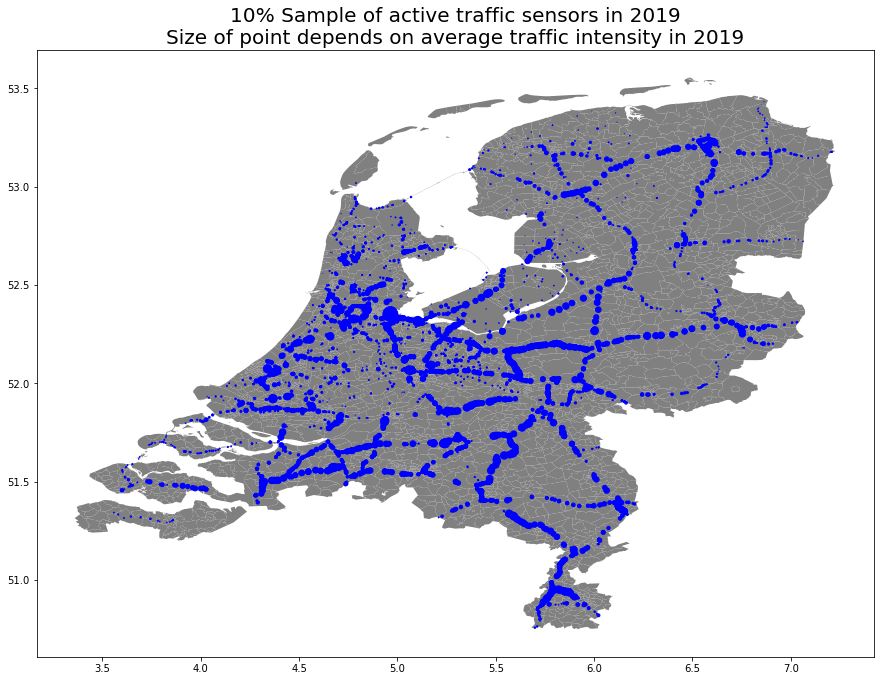

In [67]:
fig,ax = plt.subplots(figsize = (15,15)) 
nlmap.plot(ax = ax, alpha = 1, color = "grey")
gdf_year.plot(ax = ax, markersize =0.05*gdf_year["value"]**2, color = "blue", marker = "o") 
plt.title('10% Sample of active traffic sensors in 2019\nSize of point depends on average traffic intensity in 2019', fontsize = 20)
#gdf[gdf["value"] == "bluetooth"].plot(ax = ax, markersize = 20, color = "red", marker = "o")

#### Get maps for each season

In [182]:
dic = {1: "Winter",
       2: "Winter",
       3: "Spring",
       4: "Spring",
       5: "Spring",
       6: "Summer",
       7: "Summer",
       8: "Summer",
       9: "Fall",
       10: "Fall",
       11: "Fall",
       12: "Winter"}
dat['season'] = dat['month'].map(dic)

In [184]:
dat_grouped = dat[["location_id", "longitude", "latitude", "coordinates",  "value", "values_used", "month"]]
dat_grouped =  dat_grouped.groupby(["location_id", "longitude", "latitude", "coordinates", "month"], as_index = False).mean()

In [185]:
# change value for better representation on map 
dat_grouped["value2"] = dat_grouped["value"]**2

In [187]:
gdf_month = gpd.GeoDataFrame(
    dat_grouped, geometry=gpd.points_from_xy(dat_grouped.longitude, dat_grouped.latitude))

nlmap = gpd.read_file("map/wk_2019.shp")
nlmap = nlmap.to_crs("EPSG:4326") #change CRS to fit the longitude/latitude of sensor data

Text(0.5, 1.0, '10% Sample of active traffic sensors in 08/2019\nSize of point depends on average traffic intensity in 08/2019')

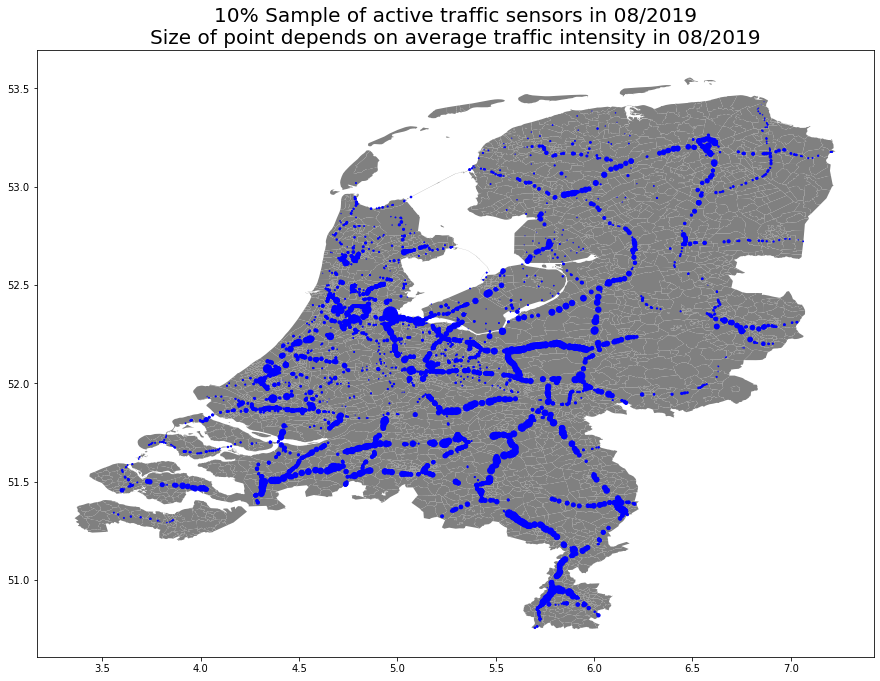

In [191]:
# August plot
gdf_aug = gdf_month.loc[gdf_month["month"] == 8]

fig,ax = plt.subplots(figsize = (15,15)) 
nlmap.plot(ax = ax, alpha = 1, color = "grey")
gdf_aug.plot(ax = ax, markersize =0.05*gdf_aug["value2"], color = "blue", marker = "o") 
plt.title('10% Sample of active traffic sensors in 08/2019\nSize of point depends on average traffic intensity in 08/2019', fontsize = 20)

Text(0.5, 1.0, '10% Sample of active traffic sensors in 05/2019\nSize of point depends on average traffic intensity in 05/2019')

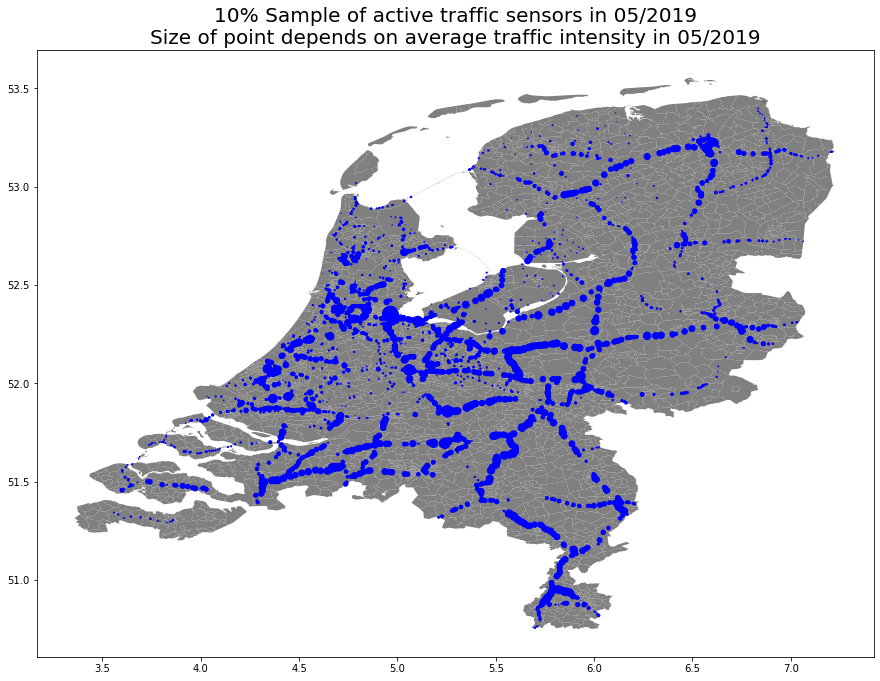

In [193]:
# May plot
gdf_may = gdf_month.loc[gdf_month["month"] == 5]

fig,ax = plt.subplots(figsize = (15,15)) 
nlmap.plot(ax = ax, alpha = 1, color = "grey")
gdf_may.plot(ax = ax, markersize =0.05*gdf_may["value2"], color = "blue", marker = "o") 
plt.title('10% Sample of active traffic sensors in 05/2019\nSize of point depends on average traffic intensity in 05/2019', fontsize = 20)

### Splitting the sensors into regions
We use one of CBS' shapefiles for provinces

In [12]:
nlmap_regions = gpd.read_file("Data/CBS/Shapefiles/Province/pv_2019.shp")
nlmap_regions = nlmap_regions.to_crs("EPSG:4326") #change CRS to fit the longitude/latitude of sensor data

<AxesSubplot:>

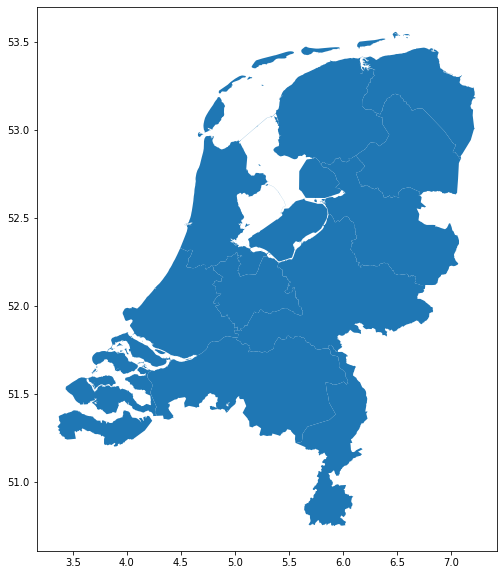

In [57]:
fig,ax = plt.subplots(figsize = (10,10)) 
nlmap_regions.plot(ax = ax)

In [60]:
#https://opendata.cbs.nl/statline/#/CBS/en/dataset/37259eng/table?ts=1639757076435
densdic = {"Groningen": 251,
       "Friesland": 194,
       "Drenthe": 187,
       "Overijssel": 348,
       "Flevoland": 295,
       "Gelderland": 417,
       "Utrecht": 904,
       "Noord-Holland": 1071,
       "Zuid-Holland": 1361,
       "Zeeland": 215,
       "Noord-Brabant": 519,
       "Limburg": 520}

nlmap_regions["pop_density"] = nlmap_regions["PV_NAAM"].map(densdic)

In [61]:
nlmap_regions["pop_density_log"] = np.log(nlmap_regions["pop_density"])
nlmap_regions["pop_density_lognorm"] = (nlmap_regions["pop_density_log"] - np.log(nlmap_regions["pop_density"].min()) ) / ( np.log(nlmap_regions["pop_density"].max()) -  np.log(nlmap_regions["pop_density"].min()))

<AxesSubplot:>

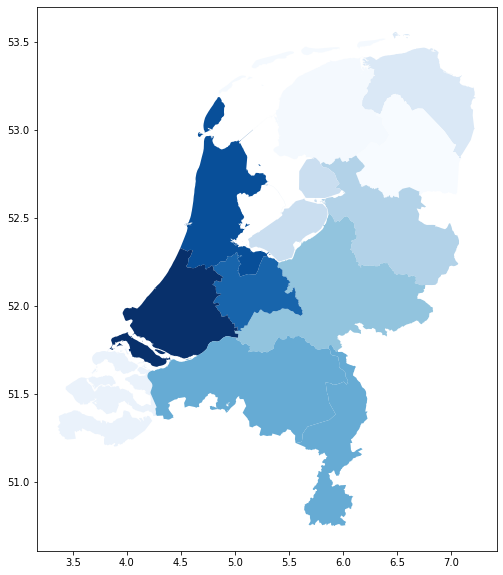

In [282]:
fig,ax = plt.subplots(figsize = (10,10)) 
nlmap_regions.plot(ax = ax, column = "pop_density_log", cmap = "Blues")

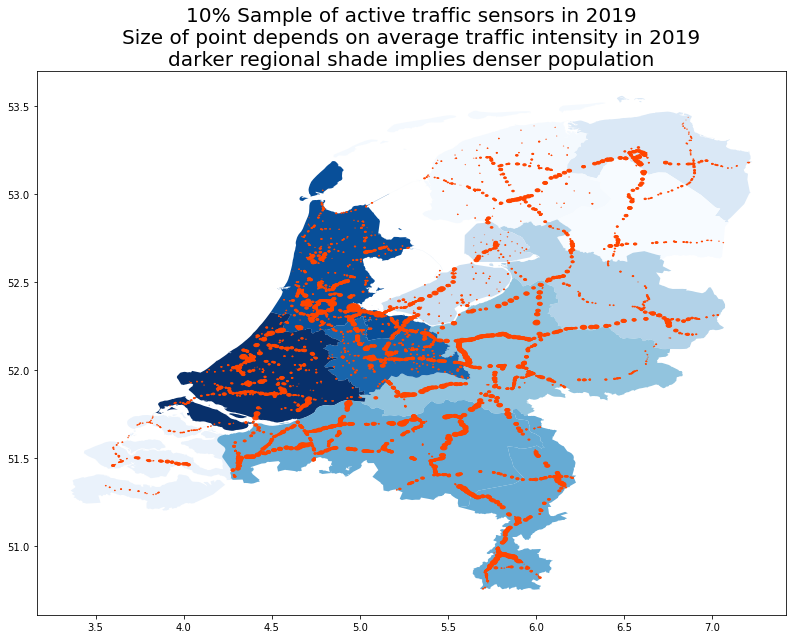

In [70]:
import matplotlib.path as mpath
circle = mpath.Path.unit_circle()
verts = np.copy(circle.vertices)
verts[:, 0] *= 1.618
ellipt_marker = mpath.Path(verts, circle.codes)

fig,ax = plt.subplots(figsize = (15,10)) 
nlmap_regions.plot(ax = ax, column = "pop_density_log", cmap = "Blues")
gdf_year.plot(ax = ax, markersize =0.04*gdf_year["value"]**2, color = "orangered", marker = ellipt_marker) 
plt.title('10% Sample of active traffic sensors in 2019\nSize of point depends on average traffic intensity in 2019\ndarker regional shade implies denser population', fontsize = 20)
#gdf[gdf["value"] == "bluetooth"].plot(ax = ax, markersize = 20, color = "red", marker = "o")

plt.savefig('map with density.png', dpi = 300)

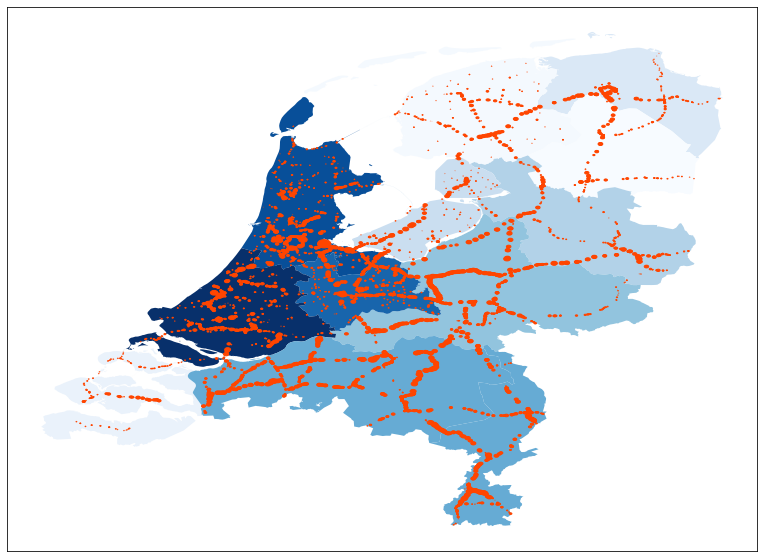

In [72]:
#making elipse marker for better visual in word document
import matplotlib.path as mpath
circle = mpath.Path.unit_circle()
verts = np.copy(circle.vertices)
verts[:, 0] *= 1.618
ellipt_marker = mpath.Path(verts, circle.codes)

#plot
fig,ax = plt.subplots(figsize = (15,10)) 
nlmap_regions.plot(ax = ax, column = "pop_density_log", cmap = "Blues")
gdf_year.plot(ax = ax, markersize =0.04*gdf_year["value"]**2, color = "orangered", marker = ellipt_marker) 
#plt.title('10% Sample of active traffic sensors in 2019\nSize of point depends on average traffic intensity in 2019\ndarker regional shade implies denser population', fontsize = 20)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig('map with density.png', dpi = 300)

# Create CSV for further steps in link_obs_exp.ipynb
This dataframe contains the location of the sensors, which will be used later.

In [79]:
gdf_year.crs  = "EPSG:4326"

In [80]:
nlmap_classified = gpd.sjoin(gdf_year, nlmap_regions, op = 'within')

/opt/Anaconda3/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [81]:
nlmap_classified_df = pd.DataFrame(nlmap_classified)

In [82]:
nlmap_classified_df.to_csv('nlmap_classified_df.csv', index=False) 